# Load data, train model

In [1]:
import shap
import pickle
import lightgbm as lgb
from sklearn.model_selection import train_test_split

In [2]:
# Load data
X, y = shap.datasets.adult()
X_display, y_display = shap.datasets.adult(display=True)
num_features = X.shape[1]

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)
d_train = lgb.Dataset(X_train, label=y_train)
d_test = lgb.Dataset(X_test, label=y_test)

In [3]:
# Train model
params = {
    "max_bin": 512,
    "learning_rate": 0.05,
    "boosting_type": "gbdt",
    "objective": "binary",
    "metric": "binary_logloss",
    "num_leaves": 10,
    "verbose": -1,
    "min_data": 100,
    "boost_from_average": True
}

model = lgb.train(params, d_train, 10000, valid_sets=[d_test], early_stopping_rounds=50, verbose_eval=1000)

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[683]	valid_0's binary_logloss: 0.277144


# SHAP cooperative game

In [4]:
from shapreg import removal, games, shapley

In [5]:
# Make model callable
model_lam = lambda x: model.predict(x)

# Model extension
marginal_extension = removal.MarginalExtension(X_test.values[:512], model_lam)

In [6]:
# Set up game (single prediction)
instance = X.values[0]
game = games.PredictionGame(marginal_extension, instance)

In [7]:
# Run estimator
explanation = shapley.ShapleyRegression(game, batch_size=32)

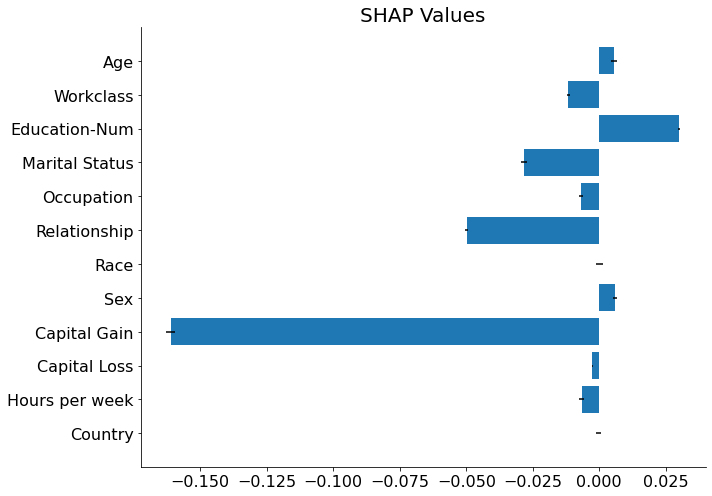

In [8]:
# Plot with 95% confidence intervals
feature_names = X.columns.tolist()
explanation.plot(feature_names, title='SHAP Values', sort_features=False)

# LossSHAP cooperative game

In [9]:
from shapreg.utils import crossentropyloss

In [10]:
# Set up game (single prediction)
instance = X.values[1]
label = y[1].astype(int)
game = games.PredictionLossGame(marginal_extension, instance, label, crossentropyloss)

In [11]:
# Run estimator
explanation = shapley.ShapleyRegression(game, batch_size=32)

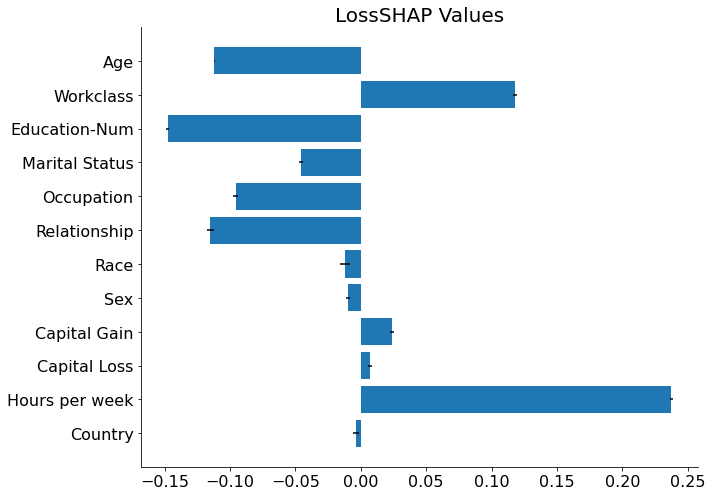

In [12]:
# Plot with 95% confidence intervals
explanation.plot(feature_names, title='LossSHAP Values', sort_features=False)